In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import probscale

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import statsmodels.api as sm
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

In [3]:
file_location = 'C:\\ames_engineered.csv'

In [4]:
f = pd.read_csv(file_location)
df = pd.DataFrame(f)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SalePrice        2617 non-null   float64
 1   LnSalePrice      2617 non-null   float64
 2   Age              2617 non-null   float64
 3   GrLivArea        2617 non-null   float64
 4   BaseLivArea      2617 non-null   float64
 5   Location         2617 non-null   int64  
 6   Amenities        2617 non-null   int64  
 7   RoadRail         2617 non-null   int64  
 8   BedroomAbvGr     2617 non-null   float64
 9   Bathrooms        2617 non-null   float64
 10  OverallCond      2617 non-null   float64
 11  OverallQual      2617 non-null   float64
 12  LotFrontage      2617 non-null   float64
 13  LotArea          2617 non-null   float64
 14  TwoStory_dum     2617 non-null   int64  
 15  FlatContour_dum  2617 non-null   int64  
 16  FlatRoof_dum     2617 non-null   int64  
 17  GarageArea    

In [6]:
# Deleting the single null value in 'GarageArea'
df = df[~df['GarageArea'].isnull()]

In [7]:
df.isnull().values.any()

False

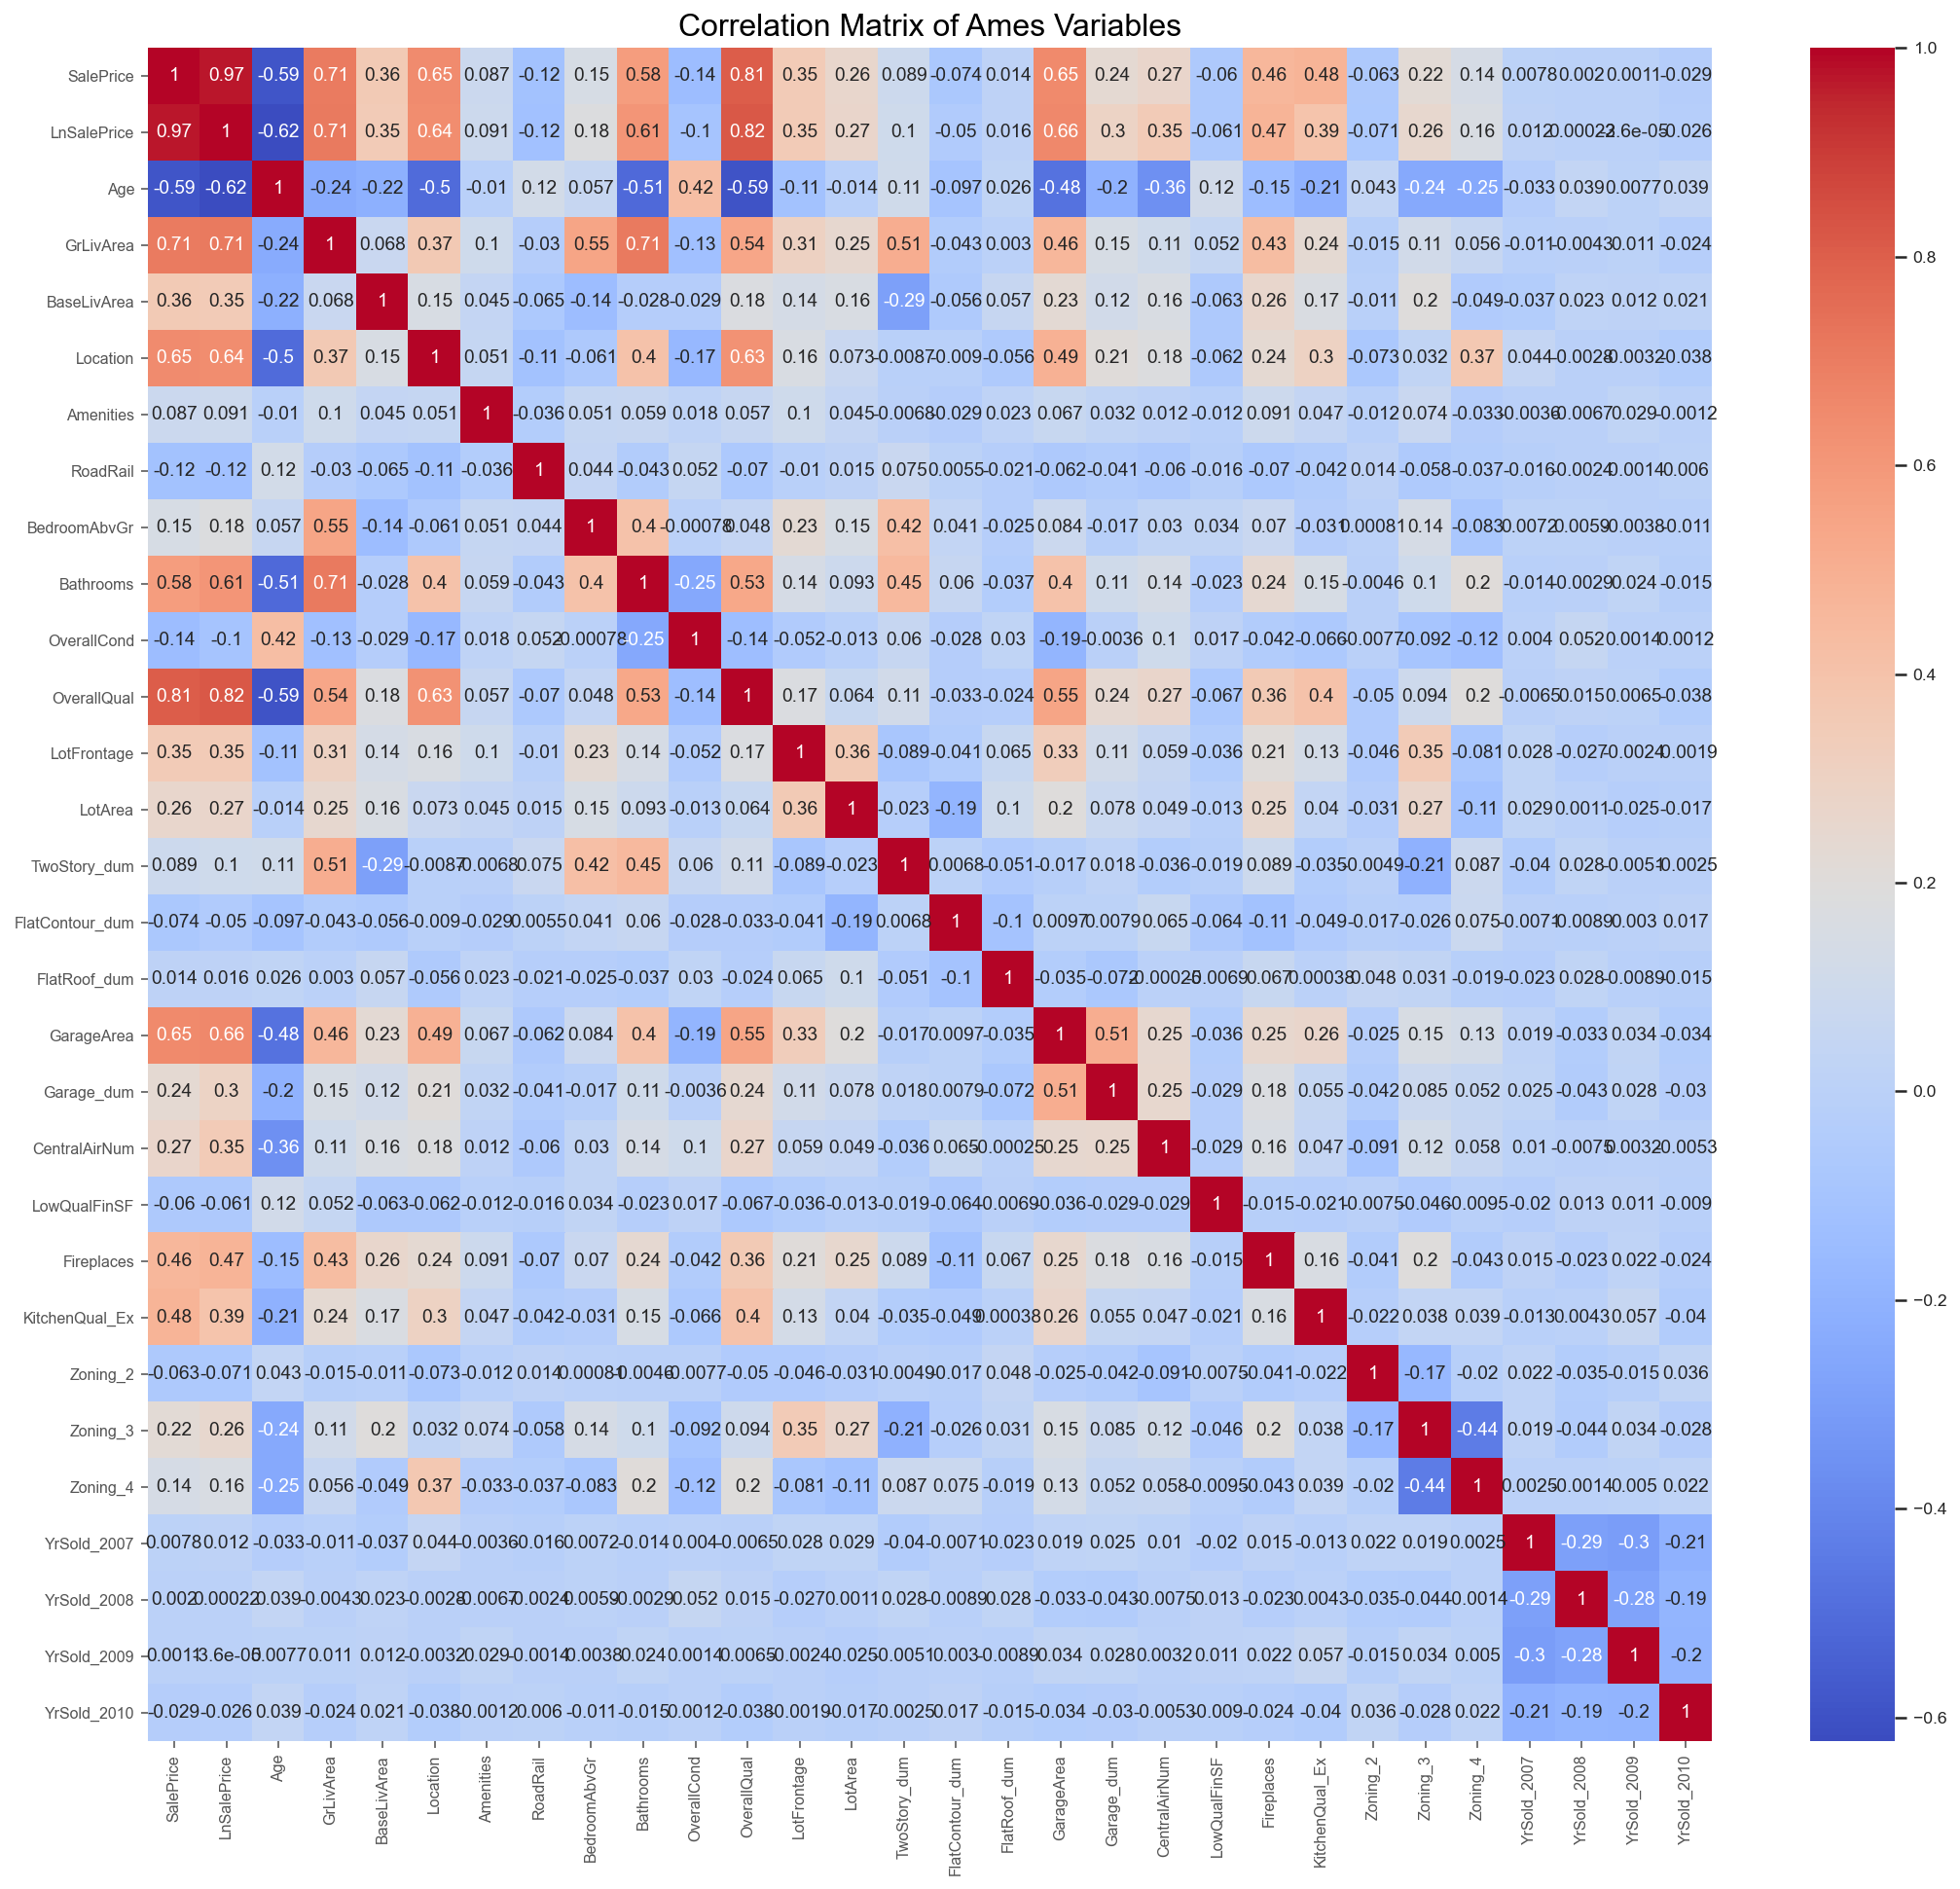

In [8]:
fig, ax = plt.subplots(figsize=(18, 16))

sns.set(font_scale=0.8)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Ames Variables", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=8)
plt.show()

The correlation matrix shows that the explanatory variables tend not to have high correlations with each other. The explanatory variable pairs that exhibit correlations is bigger than 0.70 is GrLivArea-Bathrooms. Bathrooms also has elevated correlation with Age. Given this, I decided to drop Bathrooms from the regression analysis.

In [9]:
df = df.drop(['Bathrooms'], axis=1)

### Dividing the data into pre-2010 and a 2010 holdout

Will split the data into a **pre-2010 group**, for training and testing on three linear models: OLS regression, Ridge regression and Lasso regression.

The **2020 data** will be retained as the **holdout test data** to evaluate the final model against unseen data.

In [10]:
# Assigning the 2006-2009 data to another dataset
df_0609 = df.loc[df['YrSold_2010'] != 1]
df_0609.shape

(2307, 29)

In [11]:
# Assigning 2010 data as the holdout test set
df_2010 = df.loc[df['YrSold_2010'] == 1]

# Functions

In [12]:
# Function for scoring training set
def train_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (train set)
    y: Dependant variable (train set)
    '''
    cv_scores = cross_val_score(model, X, y, cv=5) # 5-fold cross-validation

    print('Training Score:', np.round(model.score(X, y), 4))
    print('Cross-validation scores:', np.round(cv_scores, 4))
    print('Mean cross-validation score:', np.round(cv_scores.mean(), 4))

In [13]:
# Function for scoring test set
def test_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    print('Test Score:', np.round(model.score(X, y), 4))

In [14]:
# Function for MSE & RMSE scoring
def accuracy_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    yhat = model.predict(X)
    print('Mean Squared Error:', np.round(metrics.mean_squared_error(y, yhat), 4)) 
    print('Root Mean Squared Error:', np.round((metrics.mean_squared_error(y, yhat))**0.5, 4)) 

In [15]:
# Function for plotting histogram of residuals
def resid_histogram(model, X, y, period=''):
    '''
    model: fitted model
    X: Matrix of explanatory variables
    y: Dependant variable
    period: String describing data coverage period
    '''

    yhat = model.predict(X)
    residuals = y - yhat

    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(residuals, bins=50, kde=True, ax=ax)
    plt.title(f'OLS Residuals, {period}', fontsize=18);

# Regression using Ln SalePrice target on pre-2010

In [16]:
y_SP = df_0609['SalePrice']
y_lnSP = df_0609['LnSalePrice']

In [17]:
X = df_0609.drop(['SalePrice', 'LnSalePrice'], axis=1)

In [18]:
X.shape

(2307, 27)

In [19]:
# Train-test split of the 2006-2009 data
X_train, X_test, y_train, y_test = train_test_split(X, y_lnSP, test_size=0.3, random_state=8)

In [20]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [21]:
# Fitting ordinary linear regression & getting parameter estimates
ols = LinearRegression()
ols.fit(X_train, y_train)

print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)

Intercept: 12.034095130034407
Coefficients: [-8.11451502e-02  1.50836371e-01  4.16824599e-02  3.57602402e-02
  8.51432178e-04 -6.08753790e-03 -1.00074458e-02  4.72361801e-02
  1.10487503e-01  1.39485280e-02  2.24271387e-02 -2.49826516e-02
 -8.00554296e-03 -2.01677541e-06  2.30259116e-02  8.96397428e-03
  1.49051126e-02 -5.40026107e-03  1.49262032e-02  1.71861865e-02
 -2.44918613e-03  1.94764104e-02  9.61718106e-03  5.63237319e-04
  1.21379704e-03 -7.20921336e-04  0.00000000e+00]


In [22]:
# OLS training set scores, including CV scores
train_scores(ols, X_train, y_train)

Training Score: 0.916
Cross-validation scores: [0.8789 0.9275 0.9272 0.8881 0.9126]
Mean cross-validation score: 0.9069


In [23]:
# Shuffled 5-fold cross validation scores are rather similar
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_train, y_train, cv=kf)

print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

Shuffled cross validation score: [0.92   0.8973 0.9021 0.929  0.8926]
Mean shuffled cross validation score: 0.9082


In [24]:
# OLS test set score
test_scores(ols, X_test, y_test)

Test Score: 0.9142


In [25]:
# OLS MSE & RMSE scores
accuracy_scores(ols, X_test, y_test)

Mean Squared Error: 0.0112
Root Mean Squared Error: 0.1057


In [26]:
# Collect the coefficients
df_ols_coef = pd.DataFrame(ols.coef_, index=X_train.columns, columns=['Coefficients'])
df_ols_coef['Coef_abs'] = df_ols_coef.Coefficients.abs()

### Analysis of the OLS residuals

In [27]:
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)

In [28]:
# Descriptive statistics of training set residuals
ols_residuals_0609 = (y_train - predictions_train)
ols_residuals_0609.describe()

count    1.614000e+03
mean    -4.941662e-16
std      1.063799e-01
min     -5.726653e-01
25%     -6.234134e-02
50%      4.619546e-03
75%      5.943025e-02
max      4.673469e-01
Name: LnSalePrice, dtype: float64

In [29]:
# Acceptable skew and kurtosis values
print("Skew:", ols_residuals_0609.skew())
print("Kurtosis:", ols_residuals_0609.kurtosis())
stat, p = shapiro(ols_residuals_0609)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.16945817844906358
Kurtosis: 2.1447080486568284
Shapiro-Wilk test on normality=0.979, p=0.000


C:\Users\camb7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


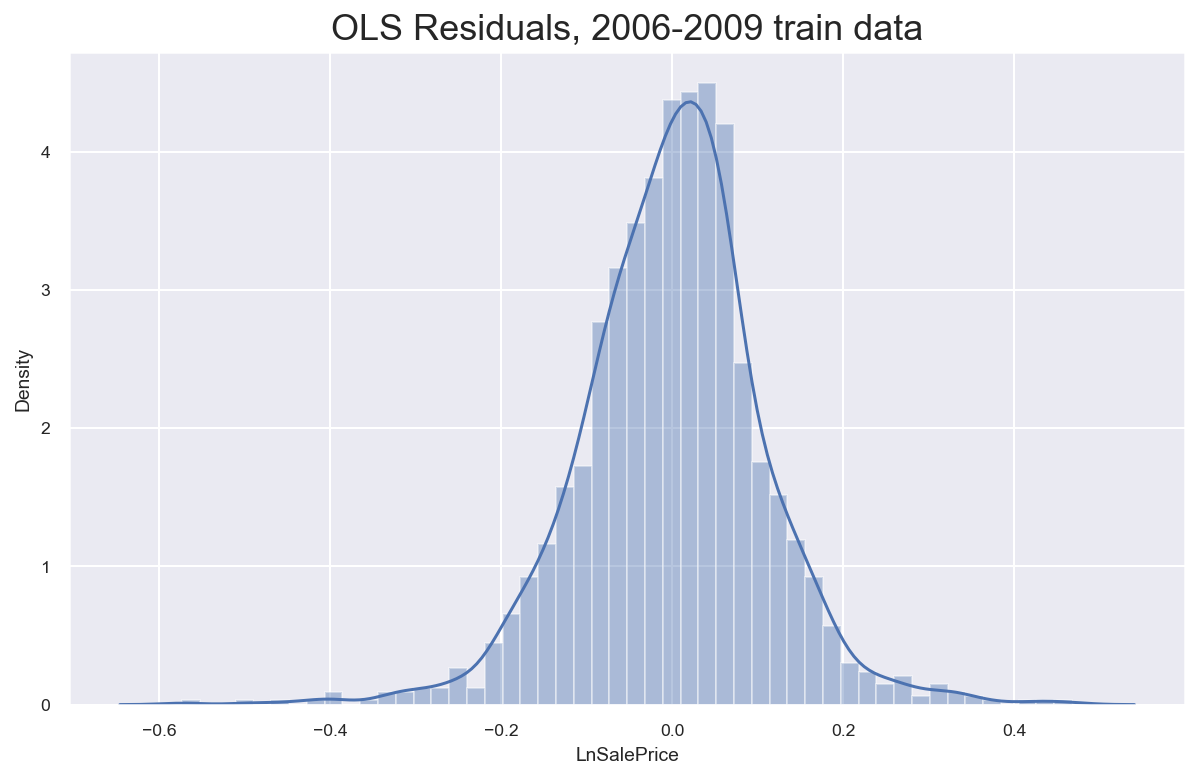

In [30]:
# Histogram of training set residuals show that they are approximately normally distributed with mean 0
# There is an indication of a left-tail, indicating that the model overpredicts the target variable
# at the very low end of 'LnSalePrice'
resid_histogram(ols, X_train, y_train, period='2006-2009 train data')

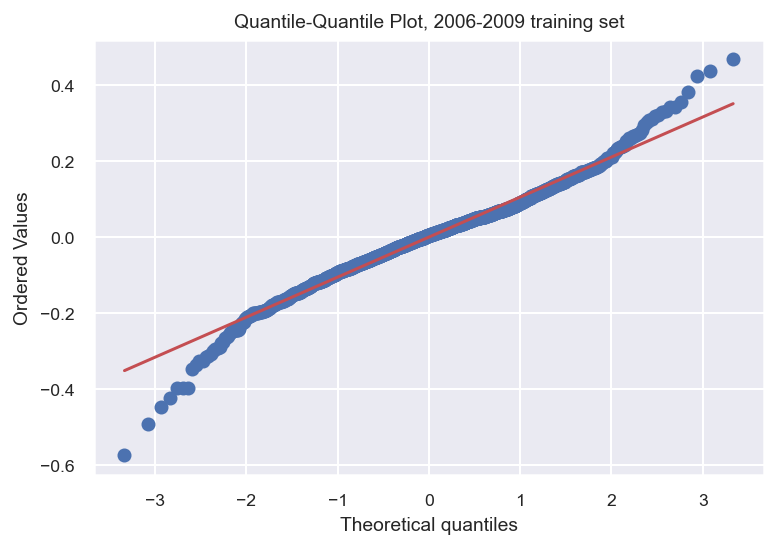

In [31]:
from scipy import stats
stats.probplot(ols_residuals_0609, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2009 training set");

In [32]:
# Descriptive statistics of test set residuals
ols_residuals_test = (y_test - predictions_test)
ols_residuals_test.describe()

count    693.000000
mean       0.003343
std        0.105772
min       -0.639473
25%       -0.055359
50%        0.005378
75%        0.058850
max        0.519638
Name: LnSalePrice, dtype: float64

C:\Users\camb7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


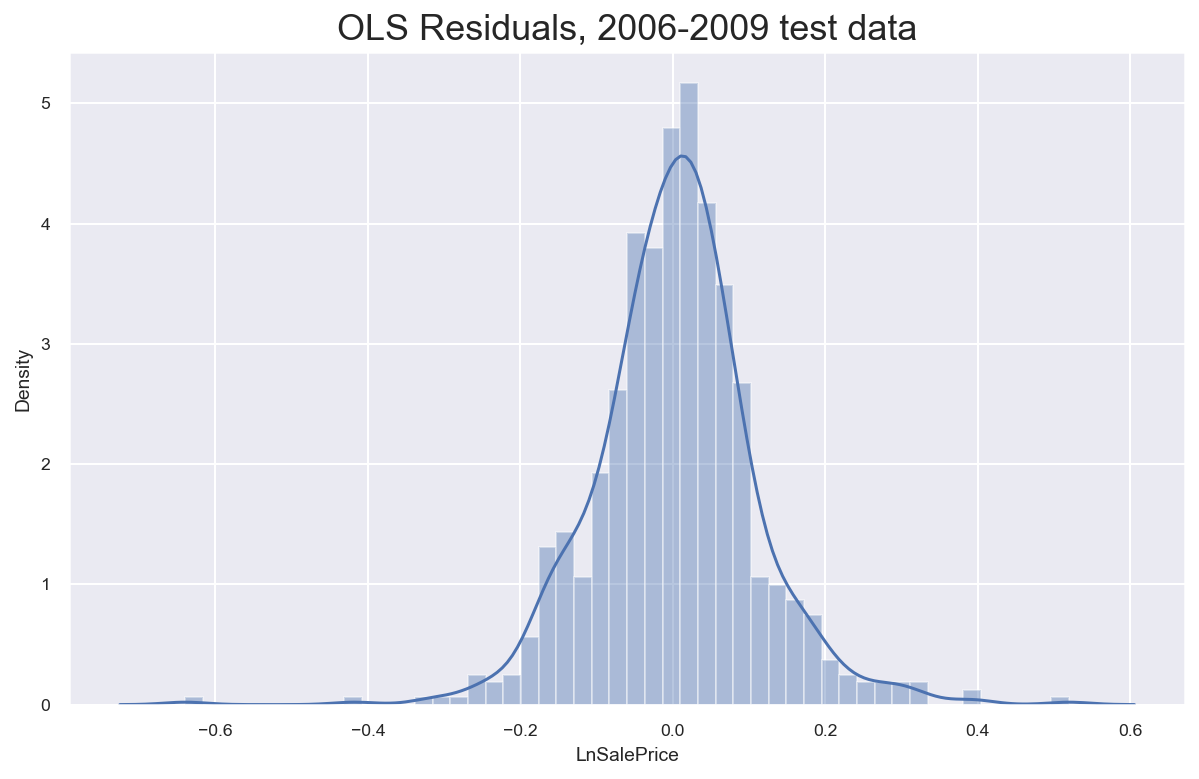

In [33]:
# Histogram of test set residuals is symmetric and approximately normal in shape
resid_histogram(ols, X_test, y_test, period='2006-2009 test data')

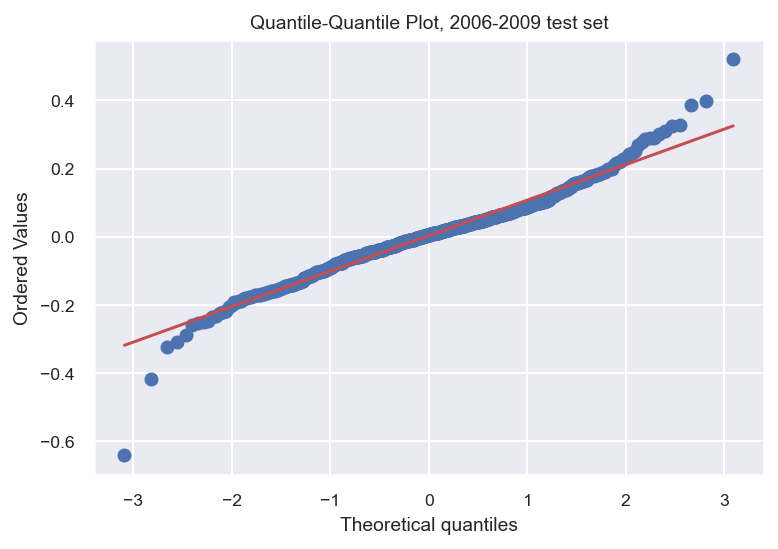

In [34]:
stats.probplot(ols_residuals_test, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2009 test set");

In [35]:
ols_residuals_test0609 = (y_test - predictions_test)
print("Skew:", ols_residuals_test0609.skew())
print("Kurtosis:", ols_residuals_test0609.kurtosis())
stat, p = shapiro(ols_residuals_test0609)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.03944538237422051
Kurtosis: 3.484659993616278
Shapiro-Wilk test on normality=0.966, p=0.000


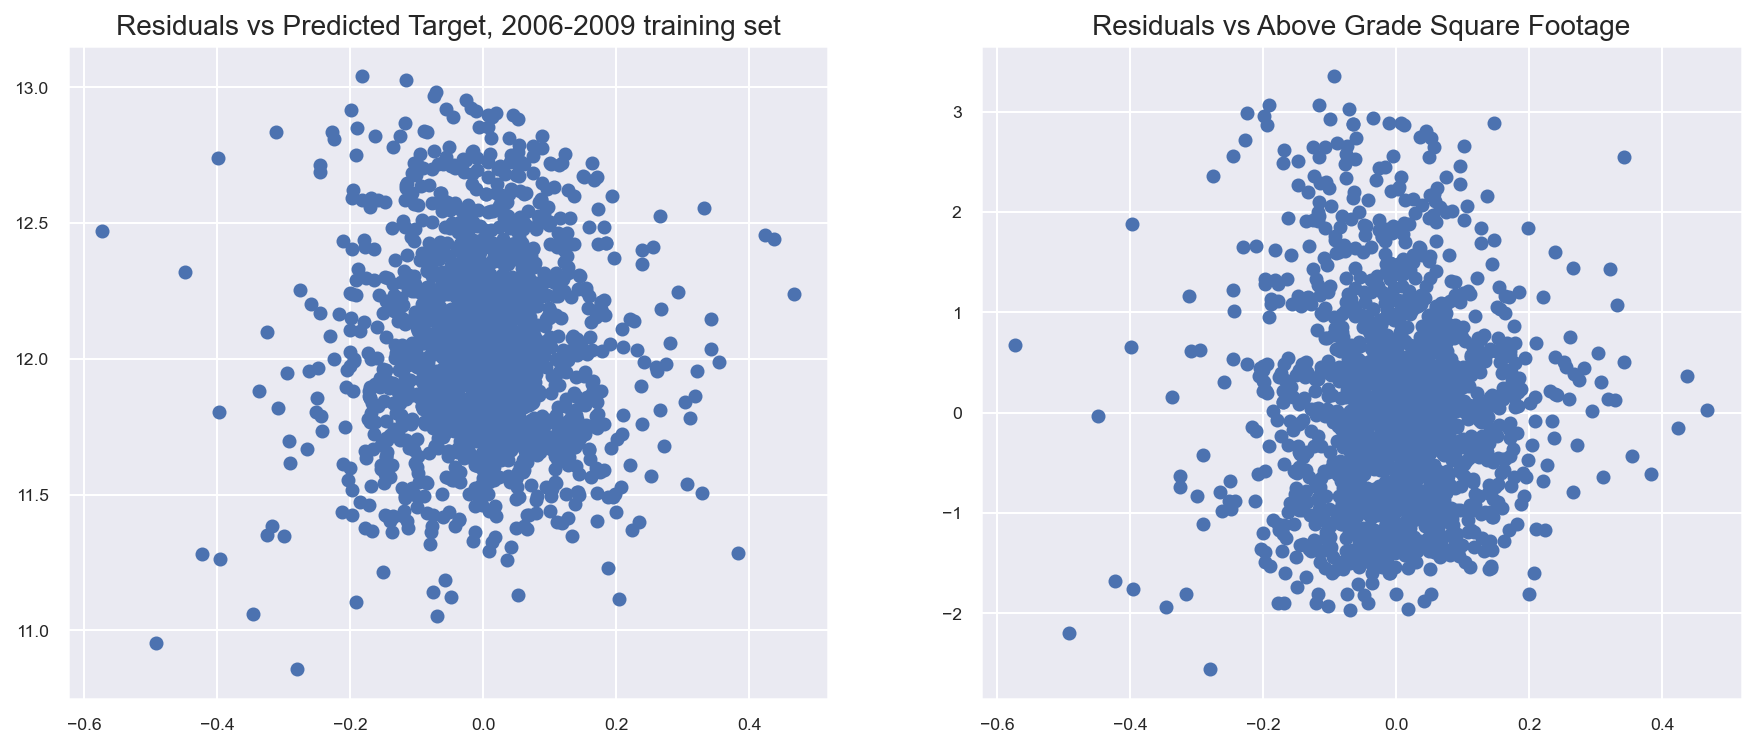

In [36]:
# Plotting the OLS residuals against the predicted-y and 'GrLivArea'. The residuals appear well-behaved
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].scatter(ols_residuals_0609, predictions_train)
ax[0].set_title('Residuals vs Predicted Target, 2006-2009 training set', fontsize=14)
ax[1].scatter(ols_residuals_0609, X_train.GrLivArea)
ax[1].set_title('Residuals vs Above Grade Square Footage', fontsize=14);

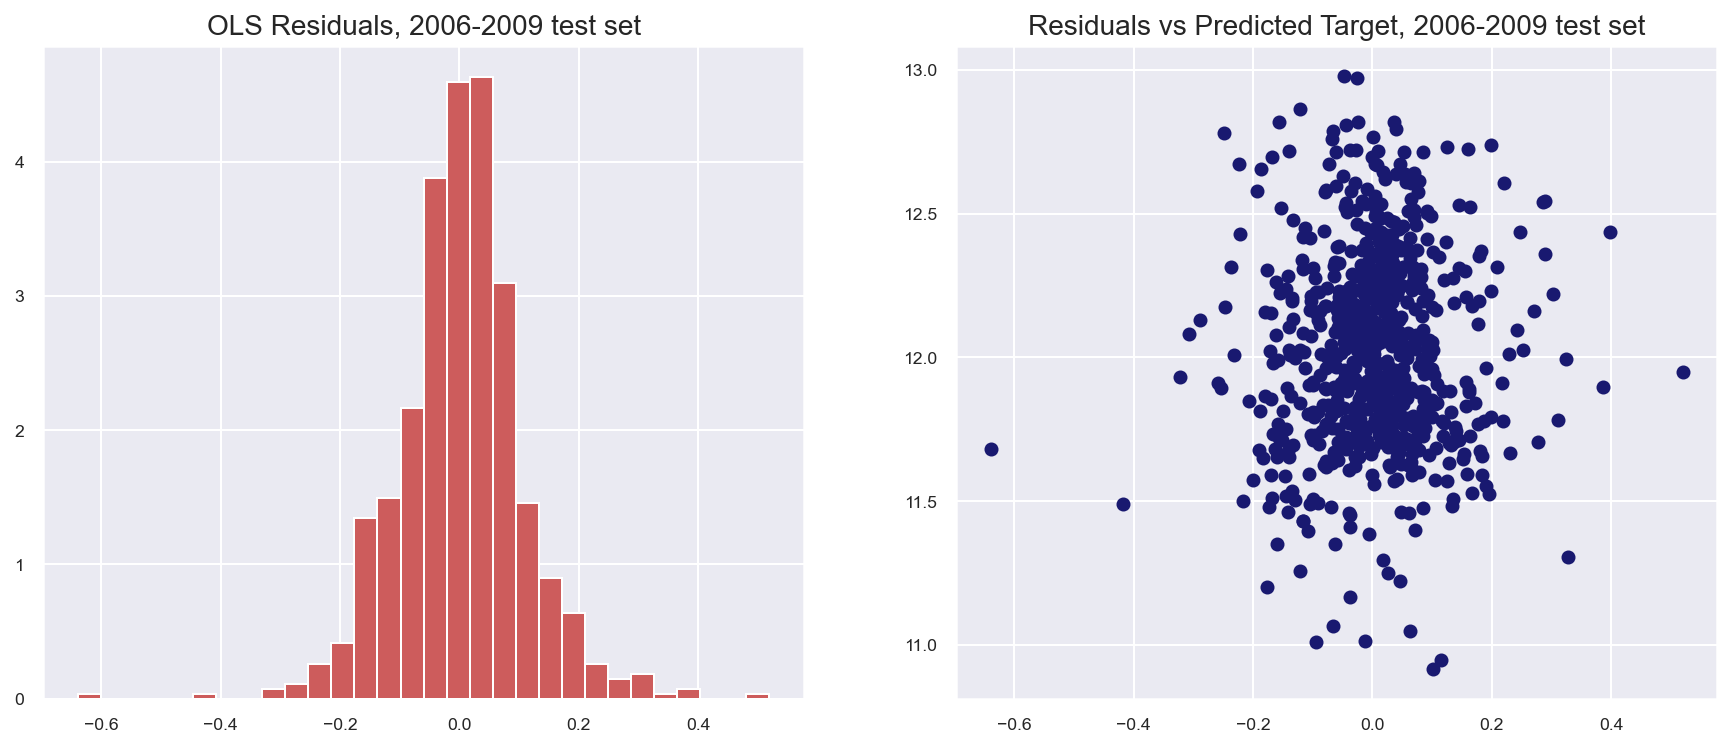

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].hist(ols_residuals_test, density=True, bins=30, color='indianred')
ax[0].set_title('OLS Residuals, 2006-2009 test set', fontsize=14)
ax[1].scatter(ols_residuals_test, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, 2006-2009 test set', fontsize=14);

## Ridge & Lasso regressions

In [38]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)

Best Ridge alpha: 21.54434690031882


In [39]:
# Ridge training set scores, including CV scores
train_scores(ridge_mod, X_train, y_train)

Training Score: 0.9159
Cross-validation scores: [0.8791 0.9275 0.926  0.8886 0.9128]
Mean cross-validation score: 0.9068


In [40]:
# Ridge test set score
test_scores(ridge_mod, X_test, y_test)

Test Score: 0.9141


In [41]:
# Confirmed similar to the above Ridge CV scores
ridge_mod = Ridge(alpha=21.544)

ridge_mod.fit(X_train, y_train)
print("Training Score:", round(ridge_mod.score(X_train, y_train), 4))
print("Test Score:", round(ridge_mod.score(X_test, y_test), 4))

Training Score: 0.9159
Test Score: 0.9141


In [42]:
# Ridge MSE & RMSE scores
accuracy_scores(ridge_mod, X_test, y_test)

Mean Squared Error: 0.0112
Root Mean Squared Error: 0.1058


In [43]:
# Collecting Ridge coefficients
df_ridge_coef = pd.DataFrame(ridge_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_ridge_coef['Coef_abs'] = df_ridge_coef.Coefficients.abs()

In [44]:
# Lasso Cross-Validation
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)

Best Lasso alpha: 0.000774263682681127


In [45]:
# Lasso training set scores, including CV scores
train_scores(lasso_mod, X_train, y_train)

Training Score: 0.9159
Cross-validation scores: [0.8803 0.9279 0.9271 0.8893 0.9134]
Mean cross-validation score: 0.9076


In [46]:
# Lasso test set score
test_scores(lasso_mod, X_test, y_test)

Test Score: 0.9139


In [47]:
# Lasso MSE & RMSE scores
accuracy_scores(lasso_mod, X_test, y_test)

Mean Squared Error: 0.0112
Root Mean Squared Error: 0.1059


In [48]:
# Collecting Lasso coefficients
df_lasso_coef = pd.DataFrame(lasso_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_lasso_coef['Coef_abs'] = df_lasso_coef.Coefficients.abs()

## Comparing the coefficients from the three linear models

In [49]:
coef_0609 = pd.concat([df_ols_coef['Coefficients'], df_ridge_coef['Coefficients'], df_lasso_coef['Coefficients']])
coef_0609 = pd.DataFrame(coef_0609)

In [50]:
coef_0609.reset_index(level=0, inplace=True)
coef_0609.columns = ['variable', 'coefficient']
coef_0609

,variable,coefficient
0,Age,-0.081145
1,GrLivArea,0.150836
2,BaseLivArea,0.041682
3,Location,0.035760
4,Amenities,0.000851
...,...,...
76,Zoning_4,0.008101
77,YrSold_2007,0.000000
78,YrSold_2008,0.000292
79,YrSold_2009,-0.000313


In [51]:
coef_0609.loc[0:26, "model"] = "ols"
coef_0609.loc[27:53, "model"] = "ridge"
coef_0609.loc[54:80, "model"] = "lasso"

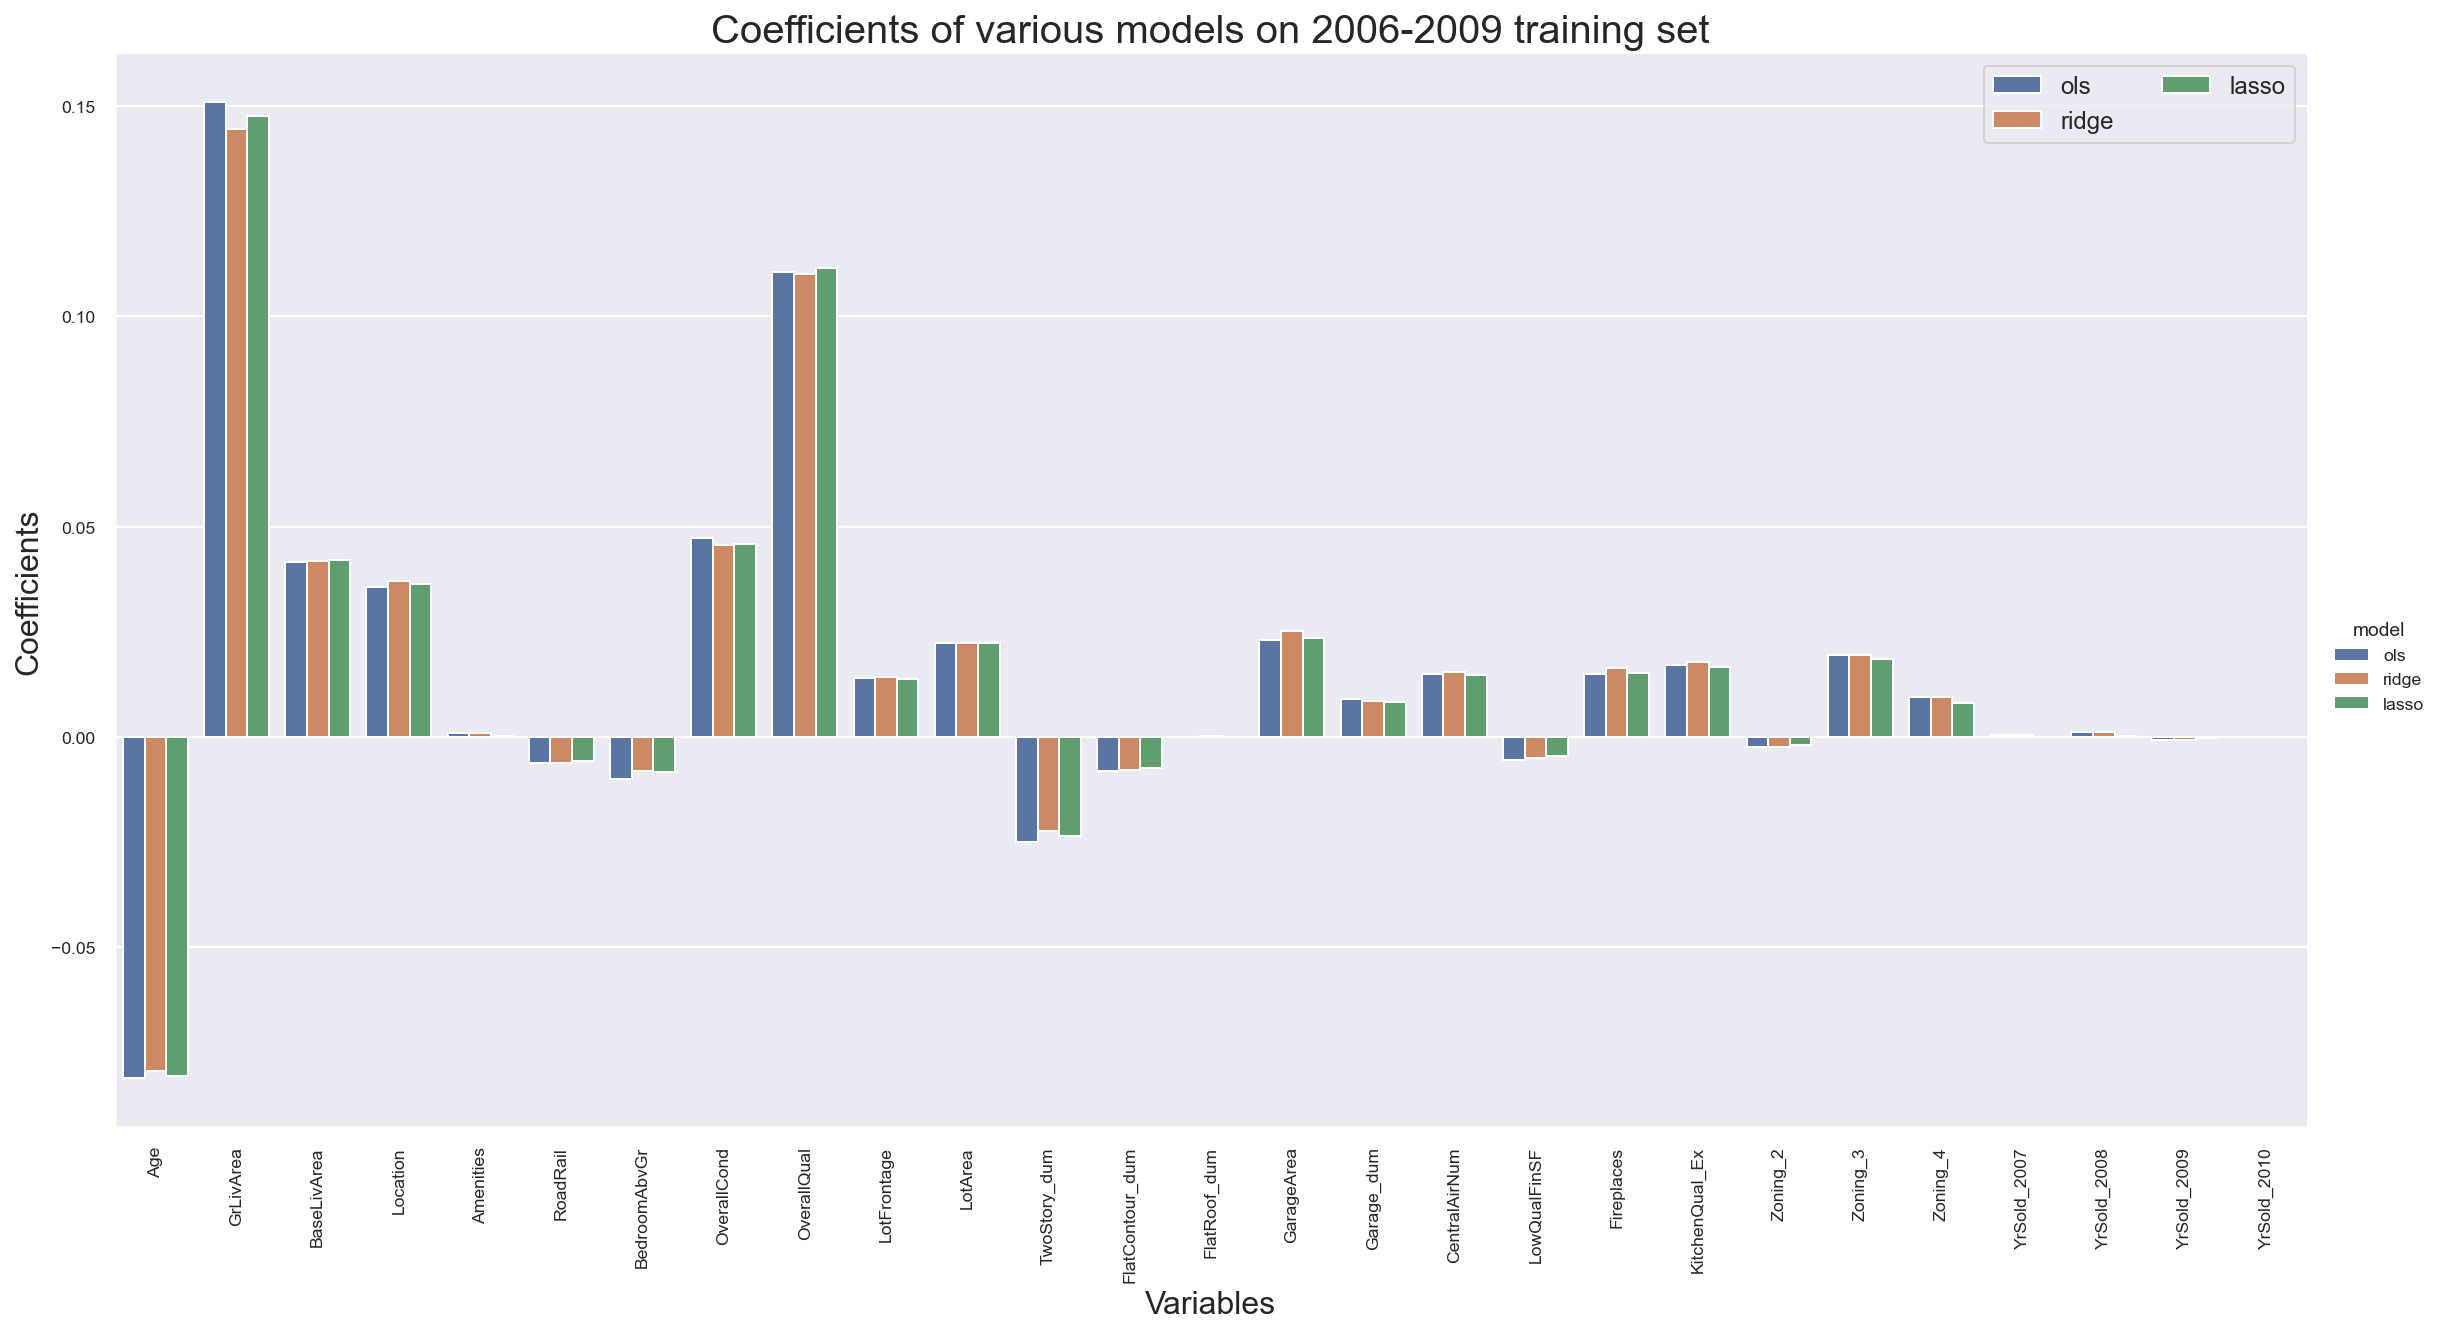

In [52]:
w = sns.catplot(x='variable', y='coefficient', hue='model', data=coef_0609, kind='bar', height=8, aspect=2)
# set rotation
w.set_xticklabels(rotation=90)

plt.title('Coefficients of various models on 2006-2009 training set', fontsize=20)
plt.xlabel("Variables", size=16)
plt.ylabel("Coefficients", size=16)
plt.legend(loc="upper right", ncol=2, fontsize=12)
plt.show()

The coefficients show that the **six more important variables** in terms of their impact size on the target are:
*GrLivArea*, *OverallQual*, *Age*, *OverCond*, *BaseLivArea*, and *Location*.

Both the coefficients and R-squared of all three linear models appear **very stable (so low variance)** across the OLS, Ridge and Lasso models. The R-squared is approximately **0.91-0.92** across all three models, and across the training and test sets too. Moreover, consistent RMSE of approximately **0.1057-0.1059** across the three models.

# Testing with 2010 Holdout Data

In [53]:
y_train = df_0609['LnSalePrice']
y_lnSP_2010 = df_2010['LnSalePrice']

In [54]:
X_2010 = df_2010.drop(['SalePrice', 'LnSalePrice'], axis=1)

In [55]:
# Using the full 2006-2009 data to train the model
X_train = df_0609.drop(['SalePrice', 'LnSalePrice'], axis=1)

In [56]:
# Setting 2010 data as the test data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_2010), columns=X_2010.columns)

In [57]:
ols.fit(X_train, y_train) 

LinearRegression()

In [58]:
# OLS training set scores, including CV scores
train_scores(ols, X_train, y_train)

Training Score: 0.916
Cross-validation scores: [0.9082 0.924  0.9068 0.8958 0.9078]
Mean cross-validation score: 0.9085


In [59]:
# OLS test set score for 2010 holdout set
test_scores(ols, X_test, y_lnSP_2010)

Test Score: 0.9015


In [60]:
# OLS MSE & RMSE scores for 2010 holdout set
accuracy_scores(ols, X_test, y_lnSP_2010)

Mean Squared Error: 0.0122
Root Mean Squared Error: 0.1105


In [61]:
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)

In [62]:
# Descriptive statistics of model residuals
ols_residuals_2010 = (y_lnSP_2010 - predictions_test)
ols_residuals_2010.describe()

count    309.000000
mean       0.015229
std        0.109649
min       -0.395574
25%       -0.048983
50%        0.025634
75%        0.081682
max        0.319854
Name: LnSalePrice, dtype: float64

In [63]:
print("Skew:", ols_residuals_2010.skew())
print("Kurtosis:", ols_residuals_2010.kurtosis())
stat, p = shapiro(ols_residuals_2010)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.44317927381464867
Kurtosis: 0.941210252764261
Shapiro-Wilk test on normality=0.984, p=0.002


C:\Users\camb7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


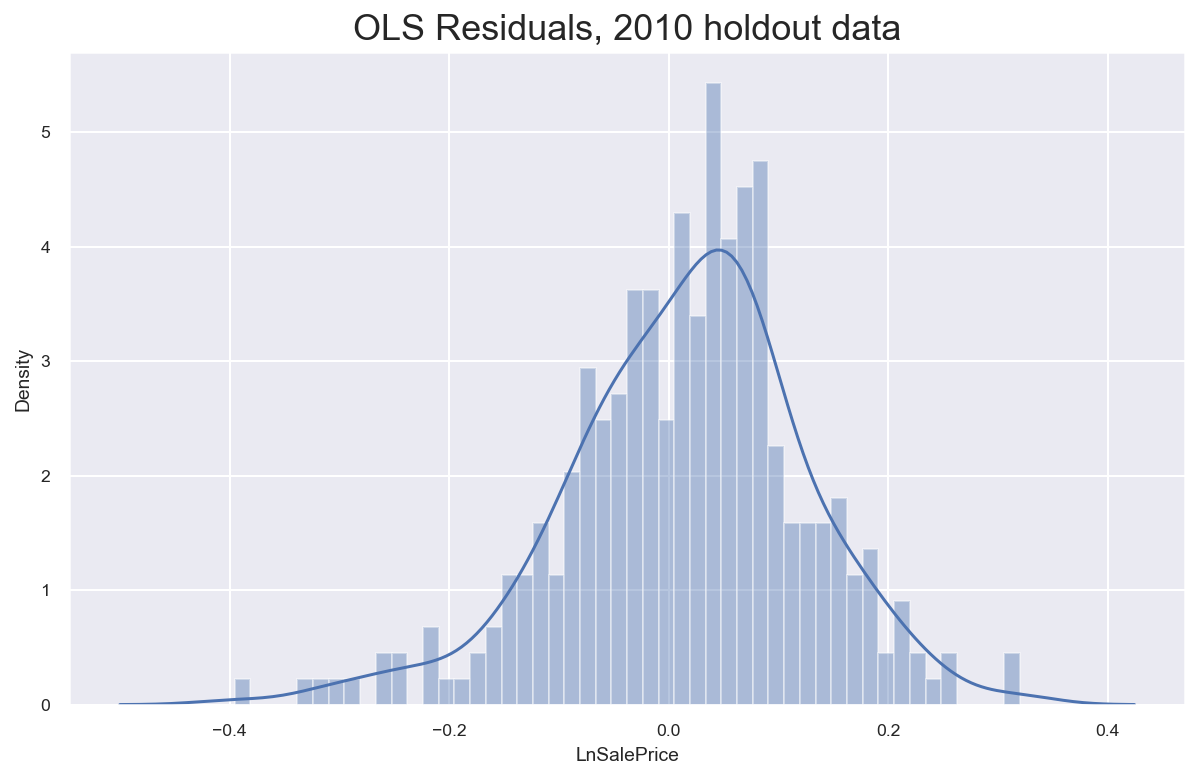

In [64]:
resid_histogram(ols, X_test, y_lnSP_2010, period='2010 holdout data')

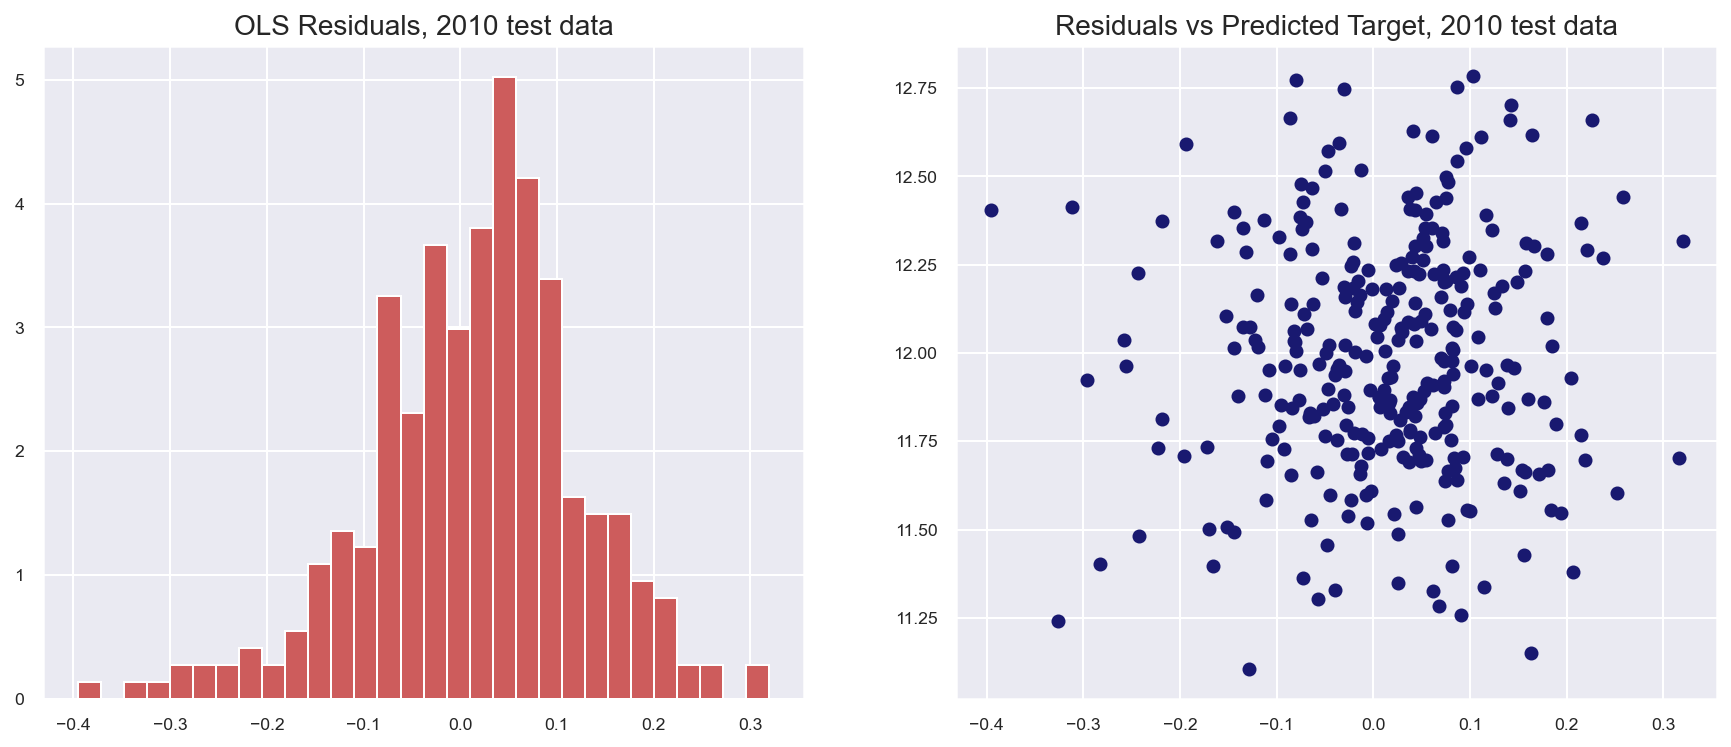

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].hist(ols_residuals_2010, density=True, bins=30, color='indianred')
ax[0].set_title('OLS Residuals, 2010 test data', fontsize=14)
ax[1].scatter(ols_residuals_2010, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, 2010 test data', fontsize=14);

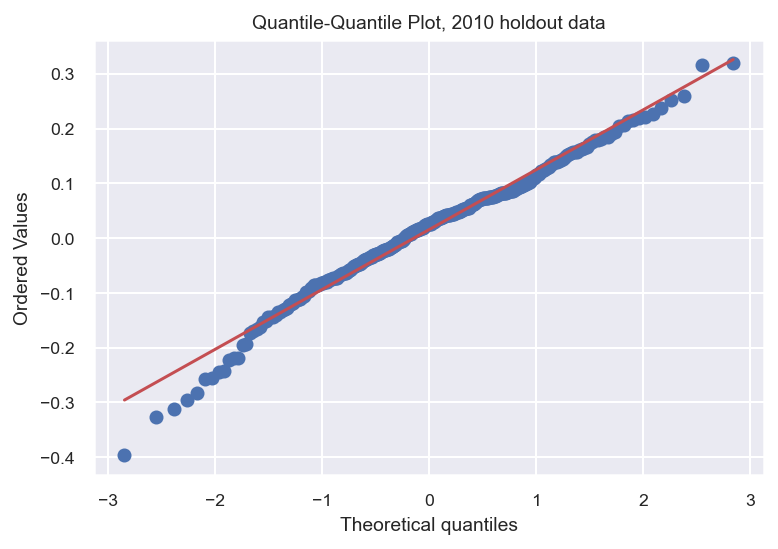

In [66]:
from scipy import stats
stats.probplot(ols_residuals_2010, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2010 holdout data")
plt.show()

## Ridge & Lasso regressions on 2010 data

In [67]:
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)

Best Ridge alpha: 21.54434690031882


In [68]:
train_scores(ridge_mod, X_train, y_train)
test_scores(ridge_mod, X_test, y_lnSP_2010)

Training Score: 0.9159
Cross-validation scores: [0.9082 0.924  0.9065 0.896  0.9085]
Mean cross-validation score: 0.9086
Test Score: 0.9016


In [69]:
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)

Best Lasso alpha: 0.000774263682681127


In [70]:
train_scores(lasso_mod, X_train, y_train)
test_scores(lasso_mod, X_test, y_lnSP_2010)

Training Score: 0.9159
Cross-validation scores: [0.9102 0.9249 0.9074 0.8966 0.9098]
Mean cross-validation score: 0.9098
Test Score: 0.9013


Using the 2010 holdout data as the test set, we see that the **R-squared drops marginally to near-0.90 in the test set** across the three linear models from the 0.91+ achieved in the 2006-2009 training set. The scores again appear **consistent across the OLS, Ridge and Lasso regressions**.

The **OLS residuals** of the 2010 data has a distribution with a very slight positive mean value and a longer left-tail, but it looks approximately normal. 

Given this, I will proceed with just the OLS regression model for **statistical inference**.

# Regression model using full 2006-2010 data

In [71]:
y_lnSP = df['LnSalePrice']

In [72]:
X_fin = df.drop(['SalePrice', 'LnSalePrice'], axis=1)

In [73]:
X_fin.shape

(2616, 27)

In [74]:
X_fin = pd.DataFrame(scaler.fit_transform(X_fin), columns=X_fin.columns)

In [75]:
ols.fit(X_fin, y_lnSP) 

LinearRegression()

In [76]:
# Model scores on the full 2006-2010 data
test_scores(ols, X_fin, y_lnSP)
accuracy_scores(ols, X_fin, y_lnSP)

Test Score: 0.9148
Mean Squared Error: 0.0113
Root Mean Squared Error: 0.1062


In [77]:
df_LnSP_coef = pd.DataFrame(ols.coef_, index=X_fin.columns,
                       columns=['Coefficients'])
df_LnSP_coef['Coef_abs'] = df_LnSP_coef.Coefficients.abs()

In [78]:
# Descriptive statistics of the residuals
predictions = ols.predict(X_fin)
error_term = (y_lnSP - predictions)
error_term.describe()

count    2.616000e+03
mean    -9.859595e-16
std      1.062177e-01
min     -6.375665e-01
25%     -6.019571e-02
50%      4.038420e-03
75%      5.920534e-02
max      4.715965e-01
Name: LnSalePrice, dtype: float64

In [79]:
# Residuals are approximately normal, given the skew and kurtosis
print("Skew:", error_term.skew())
print("Kurtosis:", error_term.kurtosis())
stat, p = shapiro(error_term)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.17607125393577763
Kurtosis: 2.310713114664527
Shapiro-Wilk test on normality=0.978, p=0.000


C:\Users\camb7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


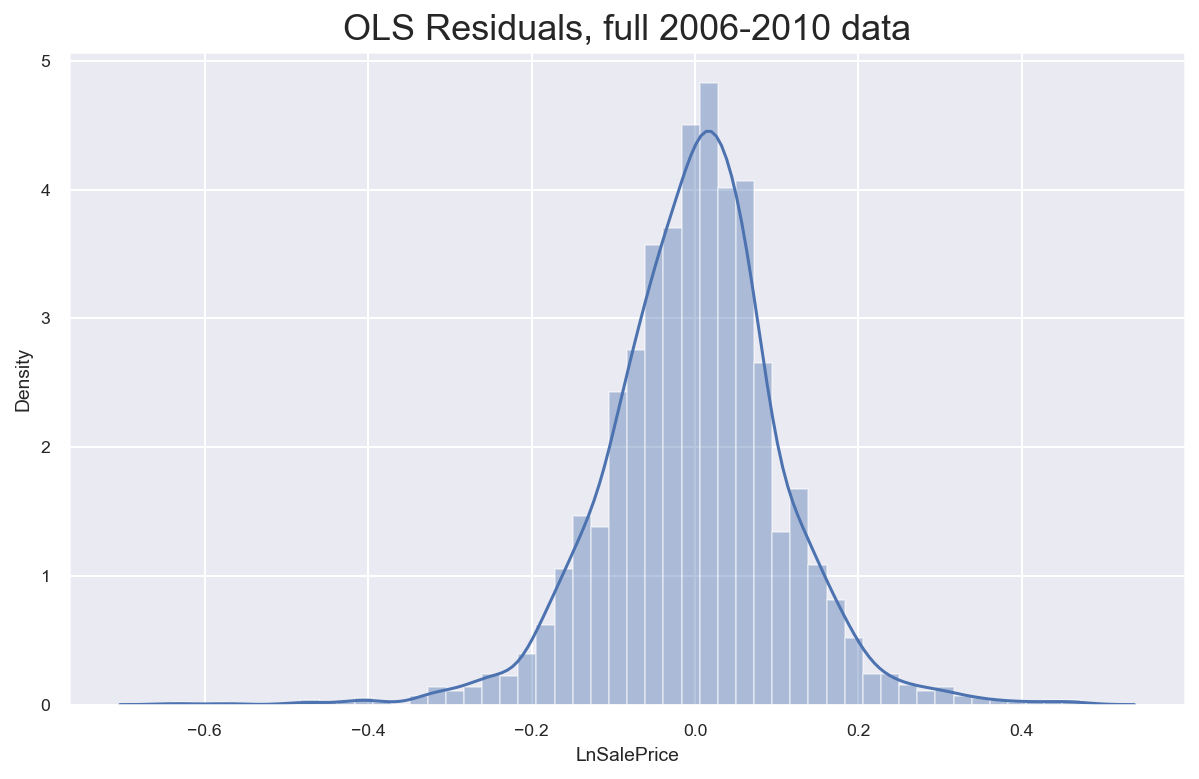

In [80]:
resid_histogram(ols, X_fin, y_lnSP, period='full 2006-2010 data')

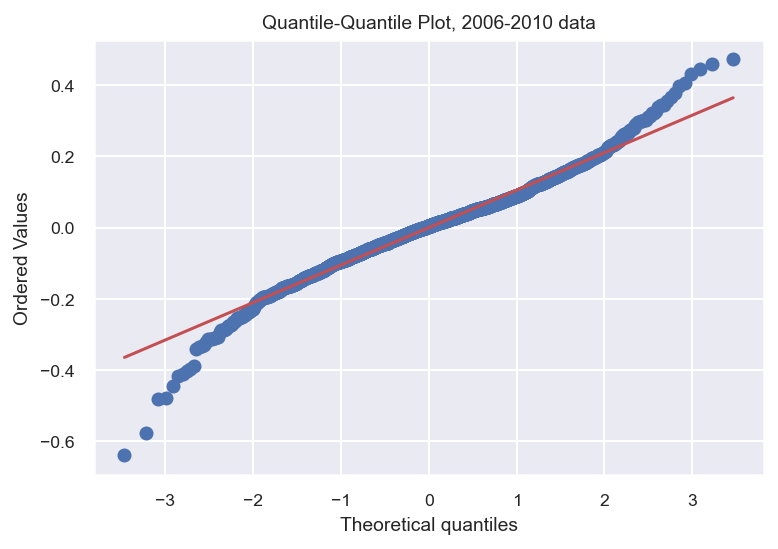

In [81]:
from scipy import stats
stats.probplot(error_term, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2010 data")
plt.show()

# Statistical inference and hypothesis testing

In [82]:
# Using the full data matrix to get the unstandardised coefficients
X_fin = df.drop(['SalePrice', 'LnSalePrice'], axis=1)

In [83]:
# Need to add a constant for the Statsmodel OLS model
X_sm = sm.add_constant(X_fin)

In [84]:
# Model using full 2006-2010 data with unstandardised values, featuring individual coefficients with p-values
model = sm.OLS(y_lnSP, X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            LnSalePrice   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1029.
Date:                Sun, 23 May 2021   Prob (F-statistic):               0.00
Time:                        18:14:04   Log-Likelihood:                 2154.3
No. Observations:                2616   AIC:                            -4253.
Df Residuals:                    2588   BIC:                            -4088.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.5389      0.024    4

 The **majority of the variables** in the OLS model are **statistically significant** at the 5% level, as indicated by the individual t-statistics and p-values. The exceptions are 'RoadRail' and 'LowQualFinSF'.

In [85]:
ols.fit(X_fin, y_lnSP)
unscaled_coef = ols.coef_

In [86]:
import math

transformed_coef = []
for i in unscaled_coef:
    j = math.exp(i)
    transformed_coef.append(j)
print(transformed_coef)

[0.9972752408705468, 1.0003329291585632, 1.00009716923651, 1.0338247623381687, 0.9855426176035118, 0.9598214705320343, 0.988369298063296, 1.0467486352268127, 1.0845439294576424, 1.000751771469628, 1.0000031846894666, 0.9552586532454207, 0.9797963059158258, 1.0341265484179938, 1.000130531339637, 1.0206625196969974, 1.070345859587567, 0.9998559869822011, 1.0264156398065571, 1.074077907916657, 0.963052462050285, 1.050908491836021, 1.0581614678622424, 1.0035490335757256, 1.0065624160320006, 0.9936692254476065, 1.015710639164118]


In [87]:
coef_effect = [(i - 1)*df.SalePrice.mean() for i in transformed_coef]

In [88]:
var_impact = pd.DataFrame(data=[X_fin.columns, coef_effect]).T

In [89]:
var_impact.columns = ["variable", "1-unit change"]

In [90]:
var_impact

,variable,1-unit change
0,Age,-487.364
1,GrLivArea,59.5493
2,BaseLivArea,17.3802
3,Location,6050.06
4,Amenities,-2585.92
5,RoadRail,-7186.52
6,BedroomAbvGr,-2080.32
7,OverallCond,8361.69
8,OverallQual,15121.9
9,LotFrontage,134.465


The DataFrame above shows the impact of a **1-unit change** in the value the respective variables on the **average sale price**. For example, a house that is **one unit** (1 year in this case) more in "Age" will cause the average sale price to drop by **\$487** all else being equal. A house that has a location score that is **one rank** higher will cause the average sale price to rise **\$6,050** all else being equal.